## Hyperparameter Tuning - Autoencoder

In [ ]:
# Load the credit card transaction fraud detection data
import pandas as pd
data = pd.read_csv("/content/creditcard.csv")

In [ ]:
## data divided into dependent and independent features
X = data.drop(['Class'],axis=1)
y = data.Class

In [ ]:
# Train-Validation-Test Dataset Split
from sklearn.model_selection import train_test_split
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.15, random_state=42)

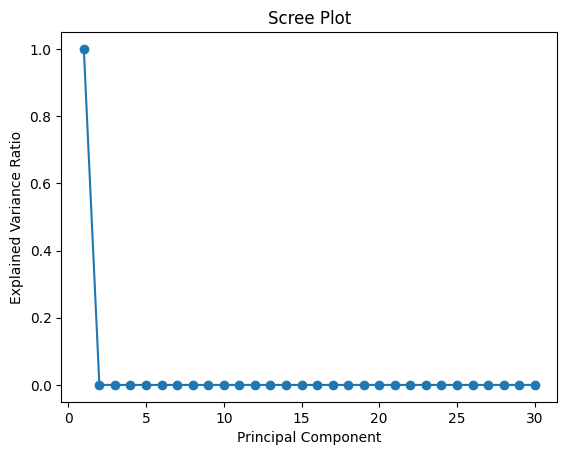

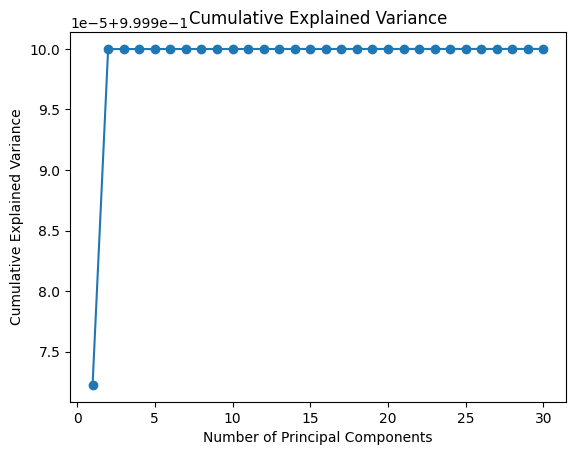

PCA = [[ 9.48138629e+04  5.59794671e+01  7.43237345e-01 ...  1.26700067e-01
  -2.14858047e-02  2.05262385e-02]
 [ 9.48138546e+04 -9.09536597e+01 -1.42895882e+00 ... -1.30074811e-02
   1.03172932e-03 -9.03447603e-03]
 [ 9.48128757e+04  2.85024840e+02  2.57569350e-01 ... -1.29493280e-01
  -2.23884515e-01 -9.65266068e-02]
 ...
 [-7.79741415e+04 -1.61186800e+01 -1.41070678e+00 ...  1.89969599e-02
  -7.73956962e-04  2.56966357e-02]
 [-7.79741447e+04 -7.39987151e+01  6.24927444e-01 ...  1.03256824e-01
   2.07836531e-02 -1.28061214e-01]
 [-7.79781331e+04  1.33004366e+02  6.33429876e-01 ... -6.40945935e-02
  -1.60044465e-01 -1.51396845e-01]]


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA

# Apply PCA to the dataset
pca = PCA()
X_pca = pca.fit_transform(X)

# Scree Plot
explained_variance_ratio = pca.explained_variance_ratio_
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot')
plt.show()

# Cumulative Explained Variance
cumulative_explained_variance = np.cumsum(explained_variance_ratio)
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance')
plt.show()

# Print PCA point
print('PCA =', X_pca)

In [ ]:
!pip install keras
!pip install tensorflow
!pip install optuna
!pip install keras tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.6/409.6 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.8/226.8 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 10.2 MB/s eta 0:00:00


In [ ]:
## Hyperparameter Tuning - Autoencoder
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import optuna
from keras.models import Sequential, Model
from keras.layers import Input, Dense
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from sklearn.decomposition import PCA

# Train-Validation-Test Dataset Split
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.15, random_state=42)

# Apply PCA for dimensionality reduction
pca = PCA()  # Initialize PCA without specifying n_components
X_train_pca = pca.fit_transform(X_train)
X_val_pca = pca.transform(X_val)
X_test_pca = pca.transform(X_test)

# Calculate cumulative explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

# Find the appropriate n_components
threshold = 0.95  # Set the threshold for cumulative explained variance ratio
n_components = np.argmax(cumulative_variance_ratio >= threshold) + 1

# Update PCA with the appropriate n_components
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train)
X_val_pca = pca.transform(X_val)
X_test_pca = pca.transform(X_test)

# Function to create the autoencoder model
def create_autoencoder_model(trial):
    input_dim = X_train_pca.shape[1]  # Use the number of components selected by PCA
    batch_size = trial.suggest_categorical('batch_size', [32, 64])
    epochs = trial.suggest_categorical('epochs', [10, 20])
    lr = trial.suggest_float('lr', 1e-5, 1e-1, log=True)

    # Define the encoder
    encoder = Sequential()
    encoder.add(Dense(32, activation='relu', input_shape=(input_dim,)))
    encoder.add(Dense(16, activation='relu'))

    # Define the decoder
    decoder = Sequential()
    decoder.add(Dense(32, activation='relu', input_shape=(16,)))
    decoder.add(Dense(input_dim, activation='sigmoid'))

    # Combine the encoder and decoder to create the autoencoder
    autoencoder_input = Input(shape=(input_dim,))
    encoded = encoder(autoencoder_input)
    decoded = decoder(encoded)
    autoencoder = Model(autoencoder_input, decoded)

    # Compile the model
    autoencoder.compile(optimizer=Adam(learning_rate=lr), loss='mean_squared_error')

    return autoencoder

# Modify the objective function to use the transformed data
def objective(trial):
    early_stopping_rounds = trial.suggest_int('early_stopping_rounds', 5, 20)
    lr = trial.suggest_float('lr', 1e-5, 1e-1, log=True)

    autoencoder_model = create_autoencoder_model(trial)

    # Early stopping setup
    early_stopping = EarlyStopping(monitor='val_loss', patience=early_stopping_rounds, restore_best_weights=True)

    # Fit the model with early stopping
    history = autoencoder_model.fit(
        X_train_pca, X_train_pca,  # Use the transformed training data
        epochs=trial.suggest_categorical('epochs', [10, 20]),
        batch_size=trial.suggest_categorical('batch_size', [32, 64]),
        validation_data=(X_val_pca, X_val_pca),  # Use the transformed validation data
        callbacks=[early_stopping],
        verbose=0
    )

    # Evaluate reconstruction error on validation set
    preds = autoencoder_model.predict(X_val_pca)
    reconstruction_error = np.mean(np.square(X_val_pca - preds))

    return float(-reconstruction_error.mean())  # Convert the mean reconstruction error to a float

# Optimize hyperparameters with Optuna
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

# Use the best parameters to train the final autoencoder model
best_params_autoencoder = study.best_params
print(best_params_autoencoder)

[I 2023-11-30 07:33:20,069] A new study created in memory with name: no-name-71dedda8-4317-4e62-be5b-c7207f5b5fe6


1069/1069 [==============================] - 2s 1ms/step


[I 2023-11-30 07:35:45,899] Trial 0 finished with value: -2255212654.1432056 and parameters: {'early_stopping_rounds': 14, 'lr': 0.005486985554407385, 'batch_size': 64, 'epochs': 20}. Best is trial 0 with value: -2255212654.1432056.


1069/1069 [==============================] - 2s 1ms/step


[I 2023-11-30 07:40:00,601] Trial 1 finished with value: -2255212654.1432056 and parameters: {'early_stopping_rounds': 20, 'lr': 0.0003166495490190437, 'batch_size': 32, 'epochs': 20}. Best is trial 0 with value: -2255212654.1432056.


1069/1069 [==============================] - 2s 1ms/step


[I 2023-11-30 07:41:25,286] Trial 2 finished with value: -2255212654.1432104 and parameters: {'early_stopping_rounds': 9, 'lr': 0.004926791414207544, 'batch_size': 64, 'epochs': 20}. Best is trial 0 with value: -2255212654.1432056.


1069/1069 [==============================] - 2s 2ms/step


[I 2023-11-30 07:43:50,680] Trial 3 finished with value: -2255212654.1432066 and parameters: {'early_stopping_rounds': 10, 'lr': 0.00010118185648494077, 'batch_size': 32, 'epochs': 10}. Best is trial 0 with value: -2255212654.1432056.


1069/1069 [==============================] - 2s 2ms/step


[I 2023-11-30 07:45:57,081] Trial 4 finished with value: -2255212654.1432056 and parameters: {'early_stopping_rounds': 12, 'lr': 0.0013529077853742415, 'batch_size': 32, 'epochs': 10}. Best is trial 0 with value: -2255212654.1432056.


1069/1069 [==============================] - 2s 1ms/step


[I 2023-11-30 07:48:22,251] Trial 5 finished with value: -2255255238.9297094 and parameters: {'early_stopping_rounds': 9, 'lr': 0.0630359228767354, 'batch_size': 32, 'epochs': 10}. Best is trial 0 with value: -2255212654.1432056.


1069/1069 [==============================] - 2s 1ms/step


[I 2023-11-30 07:50:46,965] Trial 6 finished with value: -2255212654.1432056 and parameters: {'early_stopping_rounds': 19, 'lr': 0.0036475847524405835, 'batch_size': 32, 'epochs': 10}. Best is trial 0 with value: -2255212654.1432056.


1069/1069 [==============================] - 2s 2ms/step


[I 2023-11-30 07:53:02,568] Trial 7 finished with value: -2255212654.1432056 and parameters: {'early_stopping_rounds': 20, 'lr': 0.012139858699578992, 'batch_size': 64, 'epochs': 20}. Best is trial 0 with value: -2255212654.1432056.


1069/1069 [==============================] - 2s 1ms/step


[I 2023-11-30 07:55:56,219] Trial 8 finished with value: -2255212654.1432056 and parameters: {'early_stopping_rounds': 12, 'lr': 0.0014244913670605837, 'batch_size': 32, 'epochs': 20}. Best is trial 0 with value: -2255212654.1432056.


1069/1069 [==============================] - 2s 1ms/step


[I 2023-11-30 07:57:21,677] Trial 9 finished with value: -2255212654.1432157 and parameters: {'early_stopping_rounds': 7, 'lr': 0.003989947770565984, 'batch_size': 64, 'epochs': 20}. Best is trial 0 with value: -2255212654.1432056.


1069/1069 [==============================] - 2s 2ms/step


[I 2023-11-30 07:59:49,745] Trial 10 finished with value: -2255212654.1590657 and parameters: {'early_stopping_rounds': 16, 'lr': 1.0377914117703733e-05, 'batch_size': 64, 'epochs': 20}. Best is trial 0 with value: -2255212654.1432056.


1069/1069 [==============================] - 2s 2ms/step


[I 2023-11-30 08:01:41,205] Trial 11 finished with value: -2255212654.144295 and parameters: {'early_stopping_rounds': 16, 'lr': 0.00029120493246805236, 'batch_size': 64, 'epochs': 20}. Best is trial 0 with value: -2255212654.1432056.


1069/1069 [==============================] - 2s 1ms/step


[I 2023-11-30 08:05:22,711] Trial 12 finished with value: -2255212654.1443734 and parameters: {'early_stopping_rounds': 16, 'lr': 0.00017885030232516185, 'batch_size': 32, 'epochs': 20}. Best is trial 0 with value: -2255212654.1432056.


1069/1069 [==============================] - 2s 1ms/step


[I 2023-11-30 08:07:29,875] Trial 13 finished with value: -2255255238.9297094 and parameters: {'early_stopping_rounds': 18, 'lr': 0.02570149724788781, 'batch_size': 64, 'epochs': 20}. Best is trial 0 with value: -2255212654.1432056.


1069/1069 [==============================] - 3s 2ms/step


[I 2023-11-30 08:10:57,971] Trial 14 finished with value: -2255212654.143307 and parameters: {'early_stopping_rounds': 14, 'lr': 0.0005422014573086705, 'batch_size': 32, 'epochs': 20}. Best is trial 0 with value: -2255212654.1432056.


1069/1069 [==============================] - 2s 1ms/step


[I 2023-11-30 08:13:12,547] Trial 15 finished with value: -2255255711.131152 and parameters: {'early_stopping_rounds': 14, 'lr': 0.06335093536422091, 'batch_size': 64, 'epochs': 20}. Best is trial 0 with value: -2255212654.1432056.


1069/1069 [==============================] - 2s 1ms/step


[I 2023-11-30 08:15:38,053] Trial 16 finished with value: -2255212654.1500926 and parameters: {'early_stopping_rounds': 6, 'lr': 6.441468569885804e-05, 'batch_size': 32, 'epochs': 20}. Best is trial 0 with value: -2255212654.1432056.


1069/1069 [==============================] - 2s 1ms/step


[I 2023-11-30 08:18:03,524] Trial 17 finished with value: -2255212654.1432204 and parameters: {'early_stopping_rounds': 18, 'lr': 0.0005843830365819587, 'batch_size': 64, 'epochs': 20}. Best is trial 0 with value: -2255212654.1432056.


1069/1069 [==============================] - 2s 2ms/step


[I 2023-11-30 08:20:29,163] Trial 18 finished with value: -2255212654.1432056 and parameters: {'early_stopping_rounds': 14, 'lr': 0.001648397490028267, 'batch_size': 32, 'epochs': 10}. Best is trial 0 with value: -2255212654.1432056.


1069/1069 [==============================] - 2s 1ms/step


[I 2023-11-30 08:22:54,624] Trial 19 finished with value: -2255255238.9297094 and parameters: {'early_stopping_rounds': 20, 'lr': 0.011468344575035415, 'batch_size': 64, 'epochs': 20}. Best is trial 0 with value: -2255212654.1432056.


{'early_stopping_rounds': 14, 'lr': 0.005486985554407385, 'batch_size': 64, 'epochs': 20}


## Hyperparameter Tuning - Unsupervised Learning (Clustering)

In [ ]:
## Hyperparameter tuning - Unsupervised Learning (Clustering)
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import optuna

# Load the credit card transaction fraud detection data
data = pd.read_csv("/content/creditcard.csv")

# Data divided into dependent and independent features
X = data.drop(['Class'], axis=1)
y = data.Class

# Train-Validation-Test Dataset Split
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.15, random_state=42)

# Apply PCA for dimensionality reduction
pca = PCA()  # Initialize PCA without specifying n_components
X_train_pca = pca.fit_transform(X_train)
X_val_pca = pca.transform(X_val)
X_test_pca = pca.transform(X_test)

# Calculate cumulative explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

# Find the appropriate n_components
threshold = 0.95  # Set the threshold for cumulative explained variance ratio
n_components = np.argmax(cumulative_variance_ratio >= threshold) + 1

# Update PCA with the appropriate n_components
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train)
X_val_pca = pca.transform(X_val)
X_test_pca = pca.transform(X_test)

# Objective function for Optuna with early stopping
def objective(trial):
    n_clusters = trial.suggest_int('n_clusters', 2, 5)
    n_init = trial.suggest_int('n_init', 5, 10)
    max_iter = trial.suggest_int('max_iter', 100, 500)
    tol = trial.suggest_float('tol', 1e-4, 1e-2, log=True)
    algorithm = trial.suggest_categorical('algorithm', ['lloyd', 'elkan'])

    clustering_model = KMeans(
        n_clusters=n_clusters,
        n_init=n_init,
        max_iter=max_iter,
        tol=tol,
        algorithm=algorithm,
        random_state=42
    )

    # Early stopping setup
    early_stopping_rounds = trial.suggest_int('early_stopping_rounds', 5, 20)
    previous_score = float('-inf')
    rounds_without_improvement = 0

    for epoch in range(100):  # Replace with the actual number of epochs
        clustering_model.fit(X_train_pca)

        preds = clustering_model.predict(X_val_pca)
        # Assuming you have a function to evaluate clustering performance
        score = silhouette_score(X_val_pca, preds)
        trial.report(score, step=epoch)

        # Early stopping logic
        if score <= previous_score:
            rounds_without_improvement += 1
        else:
            rounds_without_improvement = 0

        if rounds_without_improvement >= early_stopping_rounds:
            print(f"Trial {trial.number} stopped early at epoch {epoch} due to no improvement.")
            break

        previous_score = score

        # Handle pruning based on the intermediate value.
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return score

# Optimize hyperparameters with Optuna
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20, n_jobs=2)

# Retrieve best parameters
best_params_clustering = study.best_params
print(best_params_clustering)

[I 2023-11-30 06:52:06,224] A new study created in memory with name: no-name-0e3e8a11-058c-4eff-8493-e75e3d6b3c59
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1366: FutureWarning: algorithm='full' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1366: FutureWarning: algorithm='full' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1366: FutureWarning: algorithm='full' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1366: FutureWarning: algorithm='full' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1366: FutureWarning: algorithm='full' is deprecated, it will be removed

Trial 0 stopped early at epoch 8 due to no improvement.


[I 2023-11-30 06:56:29,675] Trial 1 finished with value: 0.7145251429637615 and parameters: {'n_clusters': 2, 'n_init': 5, 'max_iter': 251, 'tol': 0.0002927019275837442, 'algorithm': 'elkan', 'early_stopping_rounds': 8}. Best is trial 1 with value: 0.7145251429637615.


Trial 1 stopped early at epoch 8 due to no improvement.


[I 2023-11-30 06:59:17,562] Trial 0 finished with value: 0.5645551042670743 and parameters: {'n_clusters': 5, 'n_init': 5, 'max_iter': 485, 'tol': 0.0073199695918671585, 'algorithm': 'elkan', 'early_stopping_rounds': 11}. Best is trial 0 with value: 0.5645551042670743.


Trial 0 stopped early at epoch 11 due to no improvement.


[I 2023-11-30 07:00:58,733] Trial 1 finished with value: 0.7145299000811346 and parameters: {'n_clusters': 2, 'n_init': 7, 'max_iter': 150, 'tol': 0.0012577242256238317, 'algorithm': 'lloyd', 'early_stopping_rounds': 15}. Best is trial 1 with value: 0.7145299000811346.


Trial 1 stopped early at epoch 15 due to no improvement.


[I 2023-11-30 07:04:47,543] Trial 3 finished with value: 0.565619955155549 and parameters: {'n_clusters': 5, 'n_init': 5, 'max_iter': 243, 'tol': 0.001133283438993491, 'algorithm': 'lloyd', 'early_stopping_rounds': 8}. Best is trial 1 with value: 0.7145299000811346.


Trial 3 stopped early at epoch 8 due to no improvement.


[I 2023-11-30 07:06:30,490] Trial 2 finished with value: 0.7145486810673317 and parameters: {'n_clusters': 2, 'n_init': 5, 'max_iter': 367, 'tol': 0.009504764652463351, 'algorithm': 'elkan', 'early_stopping_rounds': 16}. Best is trial 2 with value: 0.7145486810673317.


Trial 2 stopped early at epoch 16 due to no improvement.


[I 2023-11-30 07:07:23,200] Trial 4 finished with value: 0.6318399194822205 and parameters: {'n_clusters': 3, 'n_init': 7, 'max_iter': 290, 'tol': 0.00046948938777895463, 'algorithm': 'elkan', 'early_stopping_rounds': 5}. Best is trial 2 with value: 0.7145486810673317.
[I 2023-11-30 07:07:23,264] Trial 5 pruned. 


Trial 4 stopped early at epoch 5 due to no improvement.


[I 2023-11-30 07:07:50,775] Trial 6 pruned. 
[I 2023-11-30 07:07:50,930] Trial 7 pruned. 
[I 2023-11-30 07:08:17,617] Trial 9 pruned. 
[I 2023-11-30 07:08:17,794] Trial 8 pruned. 
[I 2023-11-30 07:11:11,328] Trial 10 pruned. 
[I 2023-11-30 07:15:25,876] Trial 11 pruned. 
[I 2023-11-30 07:19:40,566] Trial 13 pruned. 
[I 2023-11-30 07:19:59,626] Trial 12 finished with value: 0.7145486810673317 and parameters: {'n_clusters': 2, 'n_init': 7, 'max_iter': 101, 'tol': 0.0025741222767255534, 'algorithm': 'elkan', 'early_stopping_rounds': 20}. Best is trial 2 with value: 0.7145486810673317.


Trial 12 stopped early at epoch 20 due to no improvement.


[I 2023-11-30 07:23:40,456] Trial 14 pruned. 
[I 2023-11-30 07:24:03,721] Trial 16 pruned. 
[I 2023-11-30 07:28:26,519] Trial 15 finished with value: 0.7145486810673317 and parameters: {'n_clusters': 2, 'n_init': 6, 'max_iter': 360, 'tol': 0.002926612351581317, 'algorithm': 'elkan', 'early_stopping_rounds': 20}. Best is trial 2 with value: 0.7145486810673317.


Trial 15 stopped early at epoch 20 due to no improvement.


[I 2023-11-30 07:28:30,148] Trial 17 pruned. 
[I 2023-11-30 07:28:54,818] Trial 19 pruned. 
[I 2023-11-30 07:31:19,532] Trial 18 pruned. 


{'n_clusters': 2, 'n_init': 5, 'max_iter': 367, 'tol': 0.009504764652463351, 'algorithm': 'elkan', 'early_stopping_rounds': 16}


## Hyperparameter Tuning - Isolation Forest

In [ ]:
## Hyperparameter Tuning - Isolated Forest
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.metrics import f1_score
from sklearn.decomposition import PCA
import optuna

# Load the credit card transaction fraud detection data
data = pd.read_csv("/content/creditcard.csv")

# Data divided into dependent and independent features
X = data.drop(['Class'], axis=1)
y = data.Class

# Train-Validation-Test Dataset Split
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.15, random_state=42)

# Apply PCA for dimensionality reduction
pca = PCA()  # Initialize PCA without specifying n_components
X_train_pca = pca.fit_transform(X_train)
X_val_pca = pca.transform(X_val)
X_test_pca = pca.transform(X_test)

# Calculate cumulative explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

# Find the appropriate n_components
threshold = 0.95  # Set the threshold for cumulative explained variance ratio
n_components = np.argmax(cumulative_variance_ratio >= threshold) + 1

# Update PCA with the appropriate n_components
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train)
X_val_pca = pca.transform(X_val)
X_test_pca = pca.transform(X_test)

# Objective function for Optuna with early stopping
def objective(trial):
    contamination = trial.suggest_float('contamination', 0.01, 0.2)
    n_estimators = trial.suggest_int('n_estimators', 50, 200)

    isolation_forest_model = IsolationForest(contamination=contamination, n_estimators=n_estimators, random_state=42)

    # Setup
    previous_score = float('-inf')
    rounds_without_improvement = 0
    max_rounds_without_improvement = 10

    for epoch in range(50):  # Reduce the number of epochs
        isolation_forest_model.fit(X_train_pca)

        preds = isolation_forest_model.predict(X_val_pca)
        # Assuming you have a function to evaluate anomaly detection performance
        score = f1_score(y_val, preds, average='weighted')  # Change 'binary' to 'weighted', 'micro', 'macro', or None
        trial.report(score, step=epoch)

        # Early stopping logic
        if score <= previous_score:
            rounds_without_improvement += 1
        else:
            rounds_without_improvement = 0

        if rounds_without_improvement >= max_rounds_without_improvement:
            break

        previous_score = score

        # Handle pruning based on the intermediate value.
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return score

# Optimize hyperparameters with Optuna
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)  # Reduce the number of trials

# Retrieve best parameters
best_params_isolation_forest = study.best_params
print(best_params_isolation_forest)

[I 2023-11-30 06:13:09,172] A new study created in memory with name: no-name-93032d6e-cf3c-4c52-8f55-f85b7dc1a348
[I 2023-11-30 06:15:30,525] Trial 0 finished with value: 3.7392055133668132e-06 and parameters: {'contamination': 0.1996415184005524, 'n_estimators': 177}. Best is trial 0 with value: 3.7392055133668132e-06.
[I 2023-11-30 06:16:43,076] Trial 1 finished with value: 3.688465458655169e-06 and parameters: {'contamination': 0.09114771364813697, 'n_estimators': 95}. Best is trial 0 with value: 3.7392055133668132e-06.
[I 2023-11-30 06:17:59,870] Trial 2 finished with value: 4.1230310311114015e-06 and parameters: {'contamination': 0.07715840476796414, 'n_estimators': 100}. Best is trial 2 with value: 4.1230310311114015e-06.
[I 2023-11-30 06:19:00,397] Trial 3 finished with value: 3.7304316152941812e-06 and parameters: {'contamination': 0.10110573350709899, 'n_estimators': 79}. Best is trial 2 with value: 4.1230310311114015e-06.
[I 2023-11-30 06:20:02,106] Trial 4 finished with valu

{'contamination': 0.01568015077933765, 'n_estimators': 192}


## Hyperparameter Tuning for Imbalance Performance - SVM

In [ ]:
## Hyperparameter Tuning - SVM
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import optuna

# Load the credit card transaction fraud detection data
data = pd.read_csv("/content/creditcard.csv")

# Data divided into dependent and independent features
X = data.drop(['Class'], axis=1)
y = data.Class

# Train-Validation-Test Dataset Split
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.15, random_state=42)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Apply PCA for dimensionality reduction
pca = PCA()  # Initialize PCA without specifying n_components
X_train_pca = pca.fit_transform(X_train_scaled)
X_val_pca = pca.transform(X_val_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Calculate cumulative explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

# Find the appropriate n_components
threshold = 0.95  # Set the threshold for cumulative explained variance ratio
n_components = np.argmax(cumulative_variance_ratio >= threshold) + 1

# Update PCA with the appropriate n_components
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train_scaled)
X_val_pca = pca.transform(X_val_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Objective function for Optuna with early stopping
def objective(trial):
    C = trial.suggest_float('C', 1e-3, 1e3, log=True)
    kernel = trial.suggest_categorical('kernel', ['linear', 'rbf', 'poly'])

    svm_model = SVC(C=C, kernel=kernel)

    # Early stopping setup
    early_stopping_rounds = trial.suggest_int('early_stopping_rounds', 5, 20)
    previous_score = float('-inf')
    rounds_without_improvement = 0

    for epoch in range(10):  # Replace with the actual number of epochs
        svm_model.fit(X_train_pca, y_train)

        preds = svm_model.predict(X_val_pca)
        score = f1_score(y_val, preds)
        trial.report(score, step=epoch)

        print(f"Epoch {epoch}: F1 Score = {score}")

        # Early stopping logic
        if score <= previous_score:
            rounds_without_improvement += 1
        else:
            rounds_without_improvement = 0

        if rounds_without_improvement >= early_stopping_rounds:
            print(f"Trial {trial.number} stopped early at epoch {epoch} due to no improvement.")
            break

        previous_score = score

        # Handle pruning based on the intermediate value.
        if trial.should_prune():
            return float('-inf')  # Return a negative infinity score to indicate pruning

    return score

# Optimize hyperparameters with Optuna
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(objective, n_trials=10)  # Change the number of trials to 20

# Retrieve best parameters
best_params_svm = study.best_params
print(best_params_svm)

[I 2023-11-30 08:49:50,612] A new study created in memory with name: no-name-0c66ab39-0ad5-418f-9c70-fd8fc8e9beae


Epoch 0: F1 Score = 0.8431372549019608
Epoch 1: F1 Score = 0.8431372549019608
Epoch 2: F1 Score = 0.8431372549019608
Epoch 3: F1 Score = 0.8431372549019608
Epoch 4: F1 Score = 0.8431372549019608
Epoch 5: F1 Score = 0.8431372549019608
Epoch 6: F1 Score = 0.8431372549019608


[I 2023-11-30 09:19:34,619] Trial 0 finished with value: 0.8431372549019608 and parameters: {'C': 0.1767016940294795, 'kernel': 'linear', 'early_stopping_rounds': 7}. Best is trial 0 with value: 0.8431372549019608.


Epoch 7: F1 Score = 0.8431372549019608
Trial 0 stopped early at epoch 7 due to no improvement.
Epoch 0: F1 Score = 0.0
Epoch 1: F1 Score = 0.0
Epoch 2: F1 Score = 0.0
Epoch 3: F1 Score = 0.0
Epoch 4: F1 Score = 0.0
Epoch 5: F1 Score = 0.0
Epoch 6: F1 Score = 0.0
Epoch 7: F1 Score = 0.0
Epoch 8: F1 Score = 0.0


[I 2023-11-30 09:29:58,072] Trial 1 finished with value: 0.0 and parameters: {'C': 0.008629132190071854, 'kernel': 'rbf', 'early_stopping_rounds': 16}. Best is trial 0 with value: 0.8431372549019608.


Epoch 9: F1 Score = 0.0
Epoch 0: F1 Score = 0.8282828282828283
Epoch 1: F1 Score = 0.8282828282828283
Epoch 2: F1 Score = 0.8282828282828283
Epoch 3: F1 Score = 0.8282828282828283
Epoch 4: F1 Score = 0.8282828282828283
Epoch 5: F1 Score = 0.8282828282828283
Epoch 6: F1 Score = 0.8282828282828283


[I 2023-11-30 09:31:09,490] Trial 2 finished with value: 0.8282828282828283 and parameters: {'C': 0.0013289448722869186, 'kernel': 'linear', 'early_stopping_rounds': 7}. Best is trial 0 with value: 0.8431372549019608.


Epoch 7: F1 Score = 0.8282828282828283
Trial 2 stopped early at epoch 7 due to no improvement.
Epoch 0: F1 Score = 0.0
Epoch 1: F1 Score = 0.0
Epoch 2: F1 Score = 0.0
Epoch 3: F1 Score = 0.0
Epoch 4: F1 Score = 0.0
Epoch 5: F1 Score = 0.0
Epoch 6: F1 Score = 0.0
Epoch 7: F1 Score = 0.0
Epoch 8: F1 Score = 0.0


[I 2023-11-30 09:52:30,469] Trial 3 finished with value: 0.0 and parameters: {'C': 0.012601639723276799, 'kernel': 'rbf', 'early_stopping_rounds': 9}. Best is trial 0 with value: 0.8431372549019608.


Epoch 9: F1 Score = 0.0
Trial 3 stopped early at epoch 9 due to no improvement.
Epoch 0: F1 Score = 0.9019607843137256
Epoch 1: F1 Score = 0.9019607843137256
Epoch 2: F1 Score = 0.9019607843137256
Epoch 3: F1 Score = 0.9019607843137256
Epoch 4: F1 Score = 0.9019607843137256
Epoch 5: F1 Score = 0.9019607843137256
Epoch 6: F1 Score = 0.9019607843137256
Epoch 7: F1 Score = 0.9019607843137256
Epoch 8: F1 Score = 0.9019607843137256


[I 2023-11-30 10:06:17,690] Trial 4 finished with value: 0.9019607843137256 and parameters: {'C': 4.689400963537685, 'kernel': 'poly', 'early_stopping_rounds': 12}. Best is trial 4 with value: 0.9019607843137256.


Epoch 9: F1 Score = 0.9019607843137256


[I 2023-11-30 10:08:33,168] Trial 5 finished with value: -inf and parameters: {'C': 51.41096648805744, 'kernel': 'poly', 'early_stopping_rounds': 5}. Best is trial 4 with value: 0.9019607843137256.


Epoch 0: F1 Score = 0.7339449541284405
Epoch 0: F1 Score = 0.8932038834951457
Epoch 1: F1 Score = 0.8932038834951457
Epoch 2: F1 Score = 0.8932038834951457
Epoch 3: F1 Score = 0.8932038834951457
Epoch 4: F1 Score = 0.8932038834951457
Epoch 5: F1 Score = 0.8932038834951457
Epoch 6: F1 Score = 0.8932038834951457
Epoch 7: F1 Score = 0.8932038834951457
Epoch 8: F1 Score = 0.8932038834951457


[I 2023-11-30 10:23:09,530] Trial 6 finished with value: 0.8932038834951457 and parameters: {'C': 4.418441521199722, 'kernel': 'poly', 'early_stopping_rounds': 20}. Best is trial 4 with value: 0.9019607843137256.


Epoch 9: F1 Score = 0.8932038834951457


[I 2023-11-30 10:25:57,194] Trial 7 finished with value: -inf and parameters: {'C': 70.85721663941601, 'kernel': 'poly', 'early_stopping_rounds': 12}. Best is trial 4 with value: 0.9019607843137256.


Epoch 0: F1 Score = 0.7272727272727273


[I 2023-11-30 10:26:20,874] Trial 8 finished with value: -inf and parameters: {'C': 0.0053979568559964445, 'kernel': 'poly', 'early_stopping_rounds': 9}. Best is trial 4 with value: 0.9019607843137256.


Epoch 0: F1 Score = 0.7586206896551724
Epoch 0: F1 Score = 0.8737864077669903
Epoch 1: F1 Score = 0.8737864077669903
Epoch 2: F1 Score = 0.8737864077669903
Epoch 3: F1 Score = 0.8737864077669903
Epoch 4: F1 Score = 0.8737864077669903
Epoch 5: F1 Score = 0.8737864077669903
Epoch 6: F1 Score = 0.8737864077669903


[I 2023-11-30 10:40:46,077] Trial 9 finished with value: 0.8737864077669903 and parameters: {'C': 9.443515687962675, 'kernel': 'poly', 'early_stopping_rounds': 7}. Best is trial 4 with value: 0.9019607843137256.


Epoch 7: F1 Score = 0.8737864077669903
Trial 9 stopped early at epoch 7 due to no improvement.
{'C': 4.689400963537685, 'kernel': 'poly', 'early_stopping_rounds': 12}
